# Pixel-Photon-Event Association Demo

This notebook demonstrates the multi-tier association capabilities of the neutron event analyzer package.

In [1]:
import neutron_event_analyzer as nea
import matplotlib.pyplot as plt
import numpy as np

## 1. Load Data

Load pixels, photons, and events from the test dataset.

In [15]:
analyser = nea.Analyse(data_folder='../tests/data/neutrons', n_threads=4,settings="in_focus")

analyser.load(
    events=True,
    photons=True,
    pixels=True,
    verbosity=0
)

Found 13 paired event-photon files.


Loading event-photon pairs:   0%|          | 0/13 [00:00<?, ?it/s]

Loaded  in total.


Loading pixels:   0%|          | 0/13 [00:00<?, ?it/s]

Loaded 98425 pixels in total.


## 2. Explore Data Structure

In [16]:
print(f"Events: {len(analyser.events_df)}")
print(f"Photons: {len(analyser.photons_df)}")
print(f"Pixels: {len(analyser.pixels_df)}")
print(f"\nPixel clustering ratio: {len(analyser.pixels_df) / len(analyser.photons_df):.1f} pixels/photon")

Events: 1122
Photons: 1402
Pixels: 98425

Pixel clustering ratio: 70.2 pixels/photon


In [17]:
analyser.pixels_df.head()

,x,y,t,tot,tof
0,230.0,0.0,0.0008,1.0,2.687500e-07
1,231.0,1.0,0.0008,1.0,2.687500e-07
2,230.0,1.0,0.0008,1.0,2.687500e-07
3,234.0,1.0,0.0008,1.0,2.687500e-07
4,230.0,2.0,0.0008,1.0,2.687500e-07


## 3. Three-Tier Association

Associate pixels → photons → events in a single call.

In [18]:
result_df = analyser.associate()


Starting Full Multi-Tier Association
Using parameters from settings file
Data available: Pixels=True, Photons=True, Events=True

Performing 3-tier association: Pixels → Photons → Events

Step 1/2: Associating pixels to photons...


Associating pixels to photons:   0%|          | 0/1402 [00:00<?, ?it/s]

✅ Matched 36327 of 98425 pixels to photons (36.9%)

Step 2/2: Associating photons to events...


Associating pairs:   0%|          | 0/13 [00:00<?, ?it/s]

✅ Matched 993 of 1402 photons (70.8%)

Step 3/3: Merging pixel-photon-event associations...
✅ 28750 pixels associated through full chain to events

Full Association Complete
Final combined dataframe has 98425 rows
Columns: ['x', 'y', 't', 'tot', 'tof', 'assoc_photon_id', 'assoc_phot_x', 'assoc_phot_y', 'assoc_phot_t', 'pixel_time_diff_ns', 'pixel_spatial_diff_px', 'assoc_event_id', 'assoc_x', 'assoc_y', 'assoc_t', 'assoc_n', 'assoc_PSD']


## 4. Association Results

In [19]:
result_df.head(10)

,x,y,t,tot,tof,assoc_photon_id,assoc_phot_x,assoc_phot_y,assoc_phot_t,pixel_time_diff_ns,pixel_spatial_diff_px,assoc_event_id,assoc_x,assoc_y,assoc_t,assoc_n,assoc_PSD
0,159.0,111.0,0.000015,1.0,3.250000e-07,1.0,160.0,111.17,0.000015,0.0,1.014347,601.0,160.0,111.17,0.000015,1.0,0.0
1,162.0,111.0,0.000015,1.0,3.250000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,160.0,109.0,0.000015,1.0,3.250000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,160.0,112.0,0.000015,1.0,3.250000e-07,1.0,160.0,111.17,0.000015,0.0,0.830000,601.0,160.0,111.17,0.000015,1.0,0.0
4,158.0,110.0,0.000015,1.0,3.250000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,161.0,111.0,0.000015,1.0,3.250000e-07,1.0,160.0,111.17,0.000015,0.0,1.014347,601.0,160.0,111.17,0.000015,1.0,0.0
6,162.0,112.0,0.000015,1.0,3.250000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,161.0,112.0,0.000015,1.0,3.250000e-07,1.0,160.0,111.17,0.000015,0.0,1.299577,601.0,160.0,111.17,0.000015,1.0,0.0
8,159.0,112.0,0.000015,1.0,3.250000e-07,1.0,160.0,111.17,0.000015,0.0,1.299577,601.0,160.0,111.17,0.000015,1.0,0.0
9,158.0,112.0,0.000015,1.0,3.250000e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
pixels_to_photons = result_df['assoc_photon_id'].notna().sum()
pixels_to_events = result_df['assoc_event_id'].notna().sum()

print(f"Pixels associated to photons: {pixels_to_photons}/{len(result_df)} ({100*pixels_to_photons/len(result_df):.1f}%)")
print(f"Pixels associated to events: {pixels_to_events}/{len(result_df)} ({100*pixels_to_events/len(result_df):.1f}%)")

Pixels associated to photons: 36327/98425 (36.9%)
Pixels associated to events: 28750/98425 (29.2%)


## 5. Visualize Association Quality

### Spatial Distribution

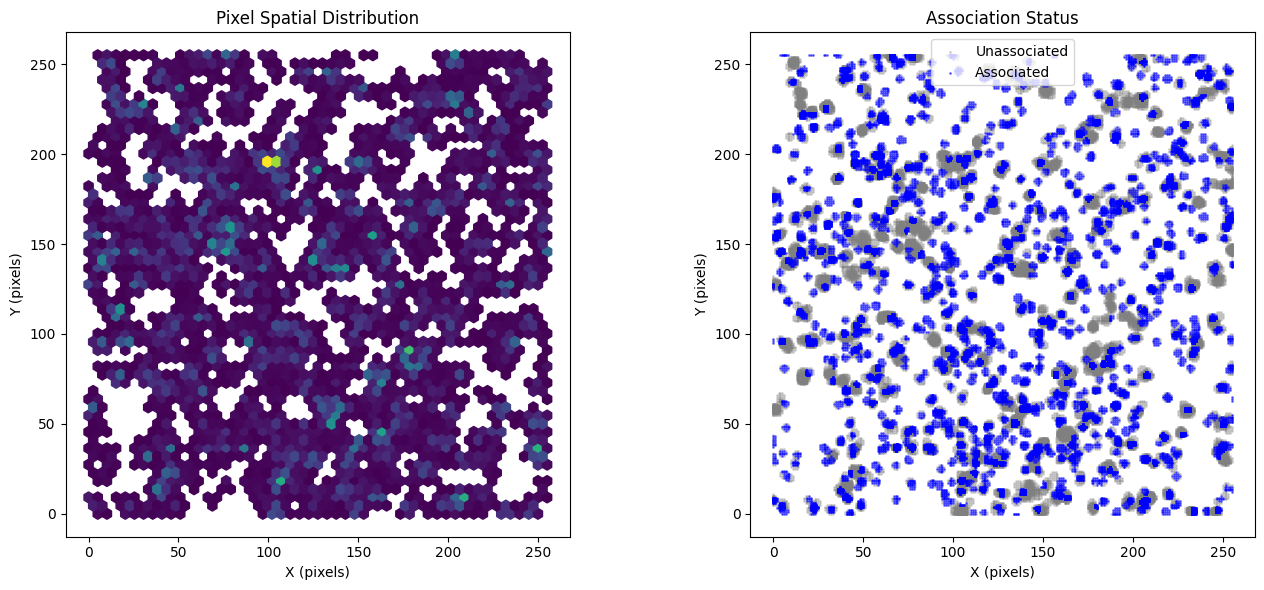

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pixel spatial distribution
axes[0].hexbin(result_df['x'], result_df['y'], gridsize=50, cmap='viridis', mincnt=1)
axes[0].set_xlabel('X (pixels)')
axes[0].set_ylabel('Y (pixels)')
axes[0].set_title('Pixel Spatial Distribution')
axes[0].set_aspect('equal')

# Associated vs unassociated pixels
associated = result_df[result_df['assoc_photon_id'].notna()]
unassociated = result_df[result_df['assoc_photon_id'].isna()]

axes[1].scatter(unassociated['x'], unassociated['y'], s=1, alpha=0.3, c='gray', label='Unassociated')
axes[1].scatter(associated['x'], associated['y'], s=1, alpha=0.5, c='blue', label='Associated')
axes[1].set_xlabel('X (pixels)')
axes[1].set_ylabel('Y (pixels)')
axes[1].set_title('Association Status')
axes[1].legend()
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

### Pixel-Photon Distance Metrics

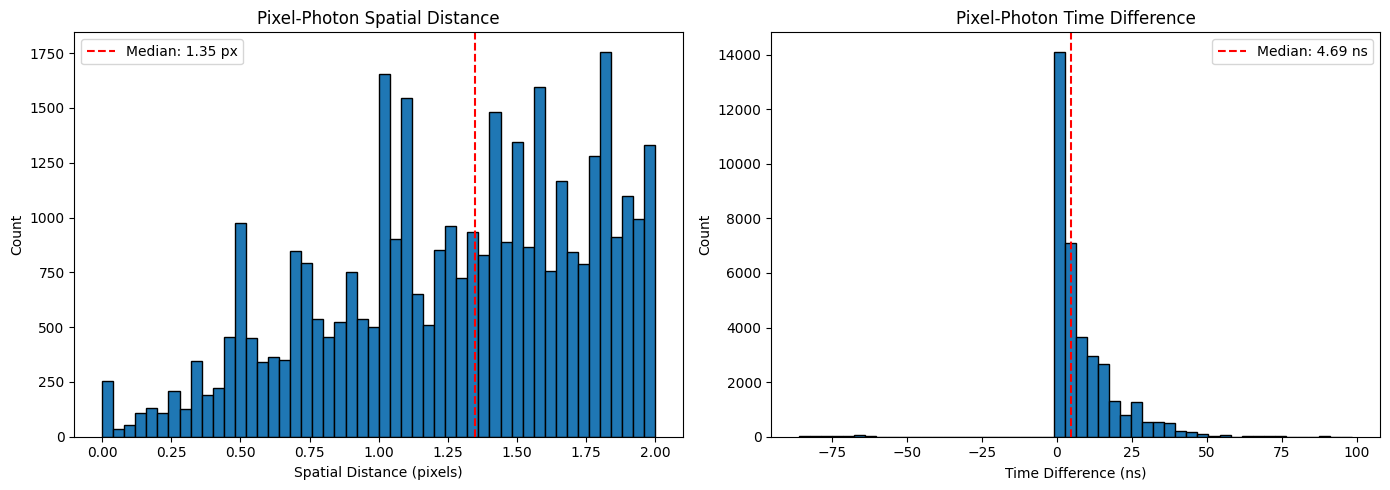

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

associated = result_df[result_df['assoc_photon_id'].notna()]

axes[0].hist(associated['pixel_spatial_diff_px'], bins=50, edgecolor='black')
axes[0].set_xlabel('Spatial Distance (pixels)')
axes[0].set_ylabel('Count')
axes[0].set_title('Pixel-Photon Spatial Distance')
axes[0].axvline(associated['pixel_spatial_diff_px'].median(), color='red', linestyle='--', label=f'Median: {associated["pixel_spatial_diff_px"].median():.2f} px')
axes[0].legend()

axes[1].hist(associated['pixel_time_diff_ns'], bins=50, edgecolor='black')
axes[1].set_xlabel('Time Difference (ns)')
axes[1].set_ylabel('Count')
axes[1].set_title('Pixel-Photon Time Difference')
axes[1].axvline(associated['pixel_time_diff_ns'].median(), color='red', linestyle='--', label=f'Median: {associated["pixel_time_diff_ns"].median():.2f} ns')
axes[1].legend()

plt.tight_layout()
plt.show()

### Time-of-Flight Distribution

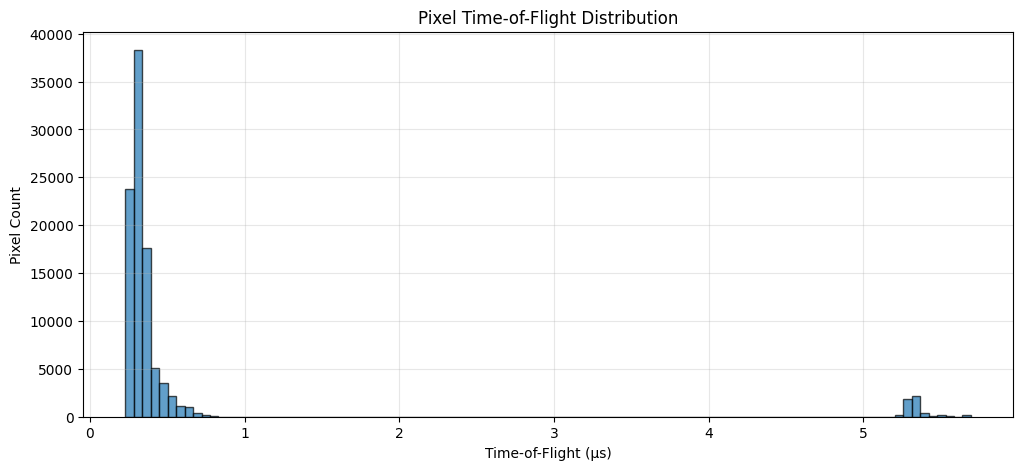

In [23]:
plt.figure(figsize=(12, 5))

plt.hist(result_df['tof'] * 1e6, bins=100, alpha=0.7, edgecolor='black')
plt.xlabel('Time-of-Flight (μs)')
plt.ylabel('Pixel Count')
plt.title('Pixel Time-of-Flight Distribution')
plt.grid(alpha=0.3)
plt.show()

## 6. Visualize Specific Event

Select an event with associated pixels and visualize the full hierarchy.

Event ID: 601.0
Pixels: 60
Photons: 1


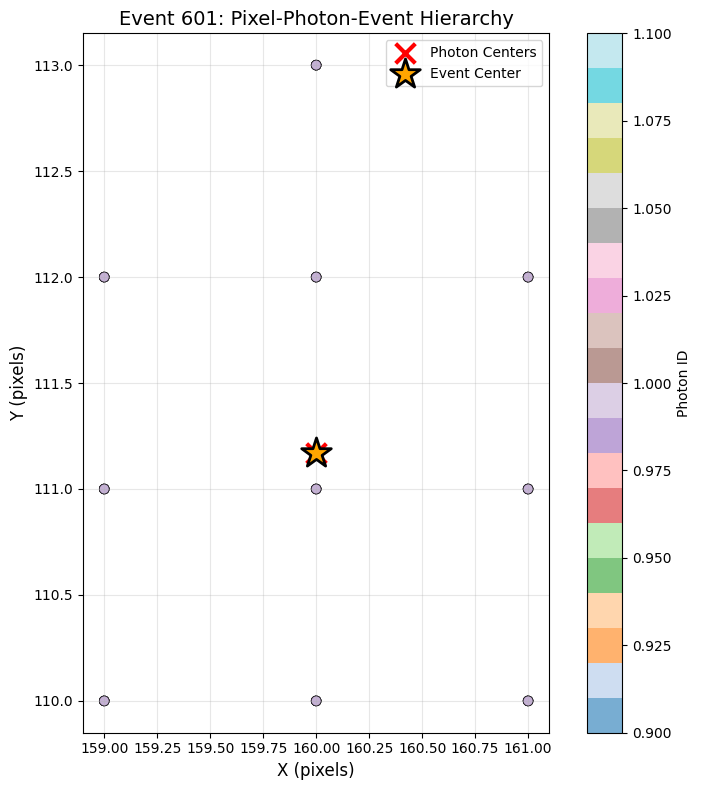

In [24]:
# Find an event with associated pixels
event_pixels = result_df[result_df['assoc_event_id'].notna()]
if len(event_pixels) > 0:
    event_id = event_pixels['assoc_event_id'].iloc[0]
    event_data = event_pixels[event_pixels['assoc_event_id'] == event_id]
    
    print(f"Event ID: {event_id}")
    print(f"Pixels: {len(event_data)}")
    print(f"Photons: {event_data['assoc_photon_id'].nunique()}")
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot pixels colored by photon association
    scatter = ax.scatter(event_data['x'], event_data['y'], 
                        c=event_data['assoc_photon_id'], 
                        cmap='tab20', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    # Plot photon centers
    photon_positions = event_data.groupby('assoc_photon_id')[['assoc_phot_x', 'assoc_phot_y']].first()
    ax.scatter(photon_positions['assoc_phot_x'], photon_positions['assoc_phot_y'], 
              marker='x', s=200, c='red', linewidths=3, label='Photon Centers')
    
    # Plot event center
    event_x = event_data['assoc_x'].iloc[0]
    event_y = event_data['assoc_y'].iloc[0]
    ax.scatter(event_x, event_y, marker='*', s=500, c='orange', 
              edgecolors='black', linewidths=2, label='Event Center', zorder=10)
    
    ax.set_xlabel('X (pixels)', fontsize=12)
    ax.set_ylabel('Y (pixels)', fontsize=12)
    ax.set_title(f'Event {int(event_id)}: Pixel-Photon-Event Hierarchy', fontsize=14)
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='Photon ID')
    plt.tight_layout()
    plt.show()
else:
    print("No events with associated pixels found.")

## 7. Cluster Size Analysis

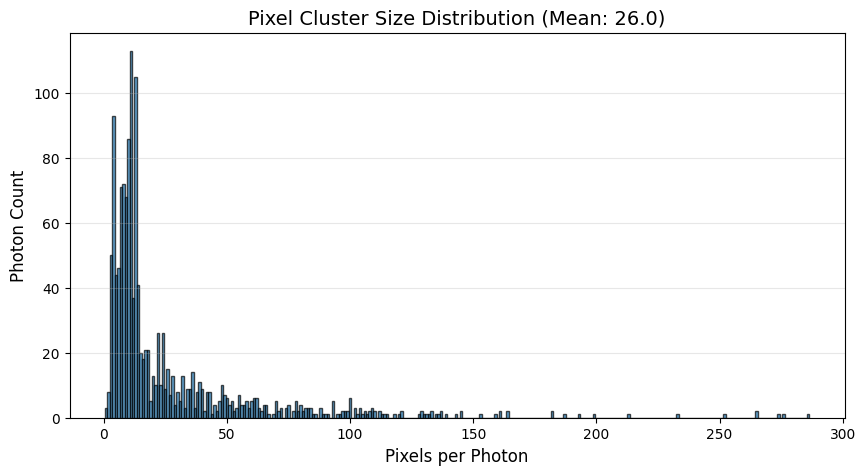

Cluster size statistics:
  Mean: 25.97 pixels/photon
  Median: 13 pixels/photon
  Std: 34.54
  Min-Max: 1-286


In [25]:
associated = result_df[result_df['assoc_photon_id'].notna()]
cluster_sizes = associated.groupby('assoc_photon_id').size()

plt.figure(figsize=(10, 5))
plt.hist(cluster_sizes, bins=np.arange(0.5, cluster_sizes.max()+1.5, 1), edgecolor='black', alpha=0.7)
plt.xlabel('Pixels per Photon', fontsize=12)
plt.ylabel('Photon Count', fontsize=12)
plt.title(f'Pixel Cluster Size Distribution (Mean: {cluster_sizes.mean():.1f})', fontsize=14)
plt.grid(alpha=0.3, axis='y')
plt.show()

print(f"Cluster size statistics:")
print(f"  Mean: {cluster_sizes.mean():.2f} pixels/photon")
print(f"  Median: {cluster_sizes.median():.0f} pixels/photon")
print(f"  Std: {cluster_sizes.std():.2f}")
print(f"  Min-Max: {cluster_sizes.min()}-{cluster_sizes.max()}")

## 8. Save Results

In [26]:
output_path = analyser.save_associations(
    filename='pixel_photon_event_associations.csv',
    verbosity=1
)

✅ Saved 98425 rows to ../tests/data/neutrons/AssociatedResults/pixel_photon_event_associations.csv
   File size: 8.15 MB
   Columns: 17


## Summary

This notebook demonstrated:
- Loading pixel, photon, and event data
- Three-tier association (pixels → photons → events)
- Visualization of association quality and metrics
- Analysis of pixel clustering and spatial distributions
- Saving results for further analysis